#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах.

<b>Цель проекта</b>

Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

<b>Задачи проекта</b>

Построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Наши шаги:

[Подготовим данные](#step_1)

[Загрузим данные и выполним их ресемплирование по одному часу.](#step_2)

[Проанализируем данные.](#step_3)

[Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.](#step_4)

[Проверим данные на тестовой выборке и сделаем выводы.](#step_5)

[Общий вывод.](#step_6)


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<a id="step_1"></a>
## Подготовка

Загрузим необходимые библиотеки

In [1]:
import pandas as pd # для работы с данными
from statsmodels.tsa.seasonal import seasonal_decompose # для декомпозиции
import matplotlib.pyplot as plt # для визуализации
from sklearn.model_selection import train_test_split # для разбиения выборок
from sklearn.metrics import mean_squared_error # для расчета MSE и RMSE
from sklearn.model_selection import GridSearchCV # для получения наилучших параметров модели
from sklearn.metrics import make_scorer # для генерации объекта скоринга
from sklearn.linear_model import LinearRegression # модель линейной регрессии
from sklearn.tree import DecisionTreeRegressor # модель дерева решений
from sklearn.ensemble import RandomForestRegressor # модель случайного дерева
from catboost import CatBoostRegressor # модель CatBoostRegressor
from lightgbm import LGBMRegressor # модель LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit # для правильного разбиения выборок для кросс-валидации

<a id="step_2"></a>
Загрузим наши данные

In [2]:
try:
    df = pd.read_csv('ataxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

Посмотрим на наши данные

In [3]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


Проверим наши данные на монотонность хронологического порядка

In [4]:
df=df.sort_index() # сортировка индекса
print(df.index.is_monotonic) # проверка сортировки

True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Т.к. нам необходимо спрогнозировать заказы такси на следующий час, рассемплируем данные по одному часу

<AxesSubplot:title={'center':'Количество заказов такси'}, xlabel='datetime'>

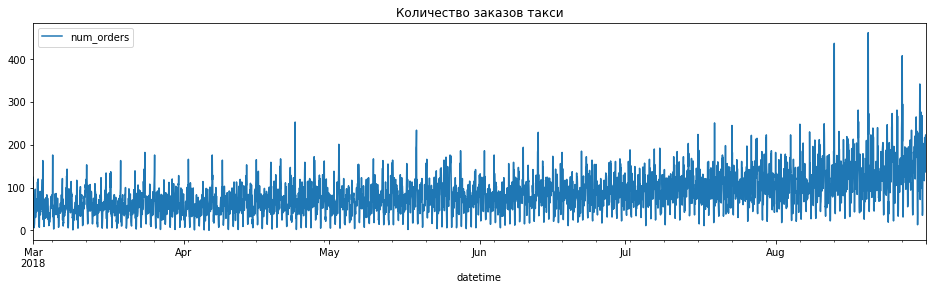

In [6]:
df=df.resample('1H').sum()
plt.figure(figsize=(16,4))
plt.title("Количество заказов такси")
df.plot(ax=plt.gca())

На этапе подготовки данных мы создали датасет с индексами временного ряда, проверили на монотонность и рассемплировали данные по 1 часу как указано в задании и необходимо нам в дальнейшем для составления прогноза количества заказов на следующий час

<a id="step_3"></a>
## Анализ

Добавим скользящее среднее с разбивкой на недельные заказы

<AxesSubplot:title={'center':'Количество заказов такси со скользящием среднем'}, xlabel='datetime'>

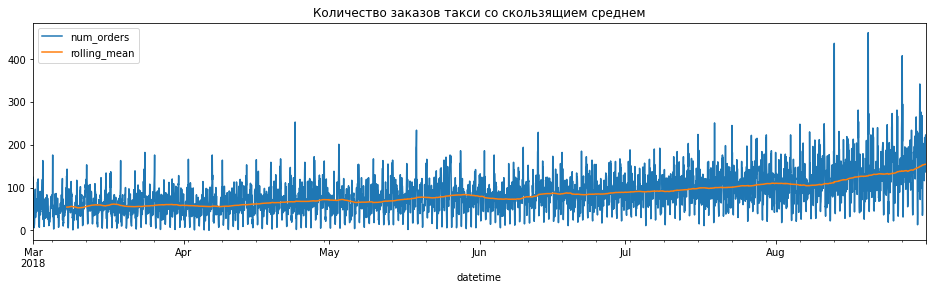

In [7]:
df['rolling_mean'] = df.rolling(24*7).mean()
plt.figure(figsize=(16,4))
plt.title("Количество заказов такси со скользящием среднем")
df.plot(ax=plt.gca())

Декомпозируем наши данные для просмотра наличия Тренда, сезонности и остатков

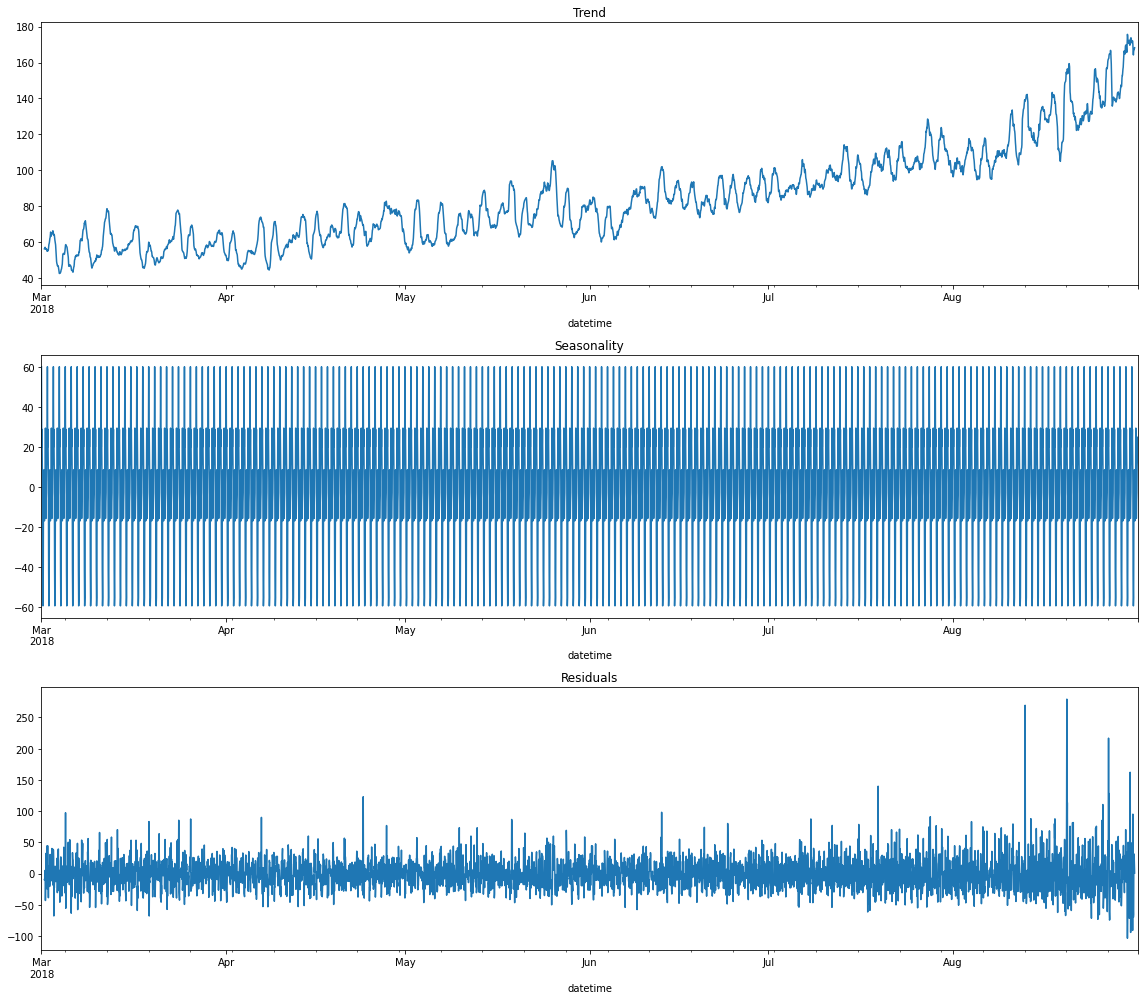

In [8]:
decomposed = seasonal_decompose(df.drop(['rolling_mean'], axis = 1))# < напишите код здесь >

plt.figure(figsize=(16, 14))
plt.subplot(311)

ax=plt.gca()
decomposed.trend.plot(ax=plt.gca()) # тренд
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca()) # сезонная составляющая
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca()) # остатки
plt.title('Residuals')
plt.tight_layout()

Наблюдаем Тренд на увеличение количества заказов в течении года.

Рассмотим сезонность заказов на отдельном примере. Возьмем первую неделю августа.

<AxesSubplot:title={'center':'Сезонность заказов в течение первых 7 дней августа'}, xlabel='datetime'>

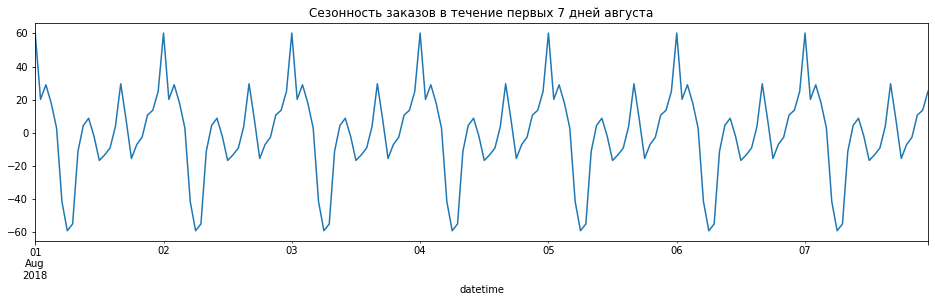

In [9]:
plt.figure(figsize=(16,4))
plt.title("Сезонность заказов в течение первых 7 дней августа")
decomposed.seasonal['2018-08-01':'2018-08-07'].plot(ax=plt.gca())

Наблюдаем каждодневную сезонность заказов. Рассмотрим на примере пары дней

<AxesSubplot:title={'center':'Сезонность заказов в течение первых 2 дней августа'}, xlabel='datetime'>

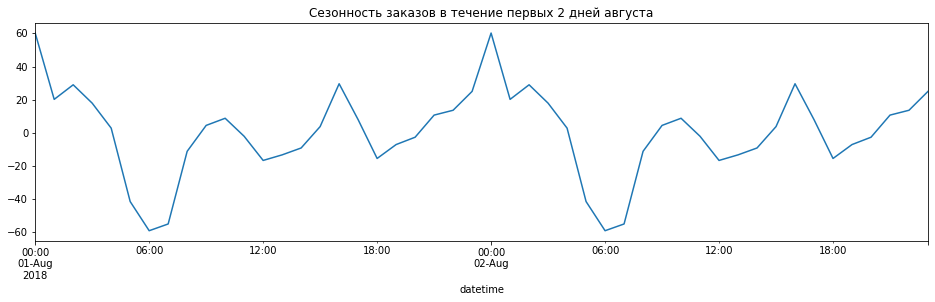

In [10]:
plt.figure(figsize=(16,4))
plt.title("Сезонность заказов в течение первых 2 дней августа")
decomposed.seasonal['2018-08-01':'2018-08-02'].plot(ax=plt.gca())

Наблюдаем пик заказов полночь и спад заказов в 6 утра

На данном этапе мы выяснили, что наблюдается тренд в заказах на увеличение в течении года. Сезонность заказов в пике приходящееся на полночь и спада в 6 утра.

По полученным данным явно наличие увеличения заказов в течении года и ближе к полуночи. Уже сейчас мы можем с уверенностью сказать, что заказов увеличивается в 10 утра, 17 вечера и растет с 18 вечера до полуночи.

<a id="step_4"></a>
## Обучение

Создадим функцию добавления фичей

In [11]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    data = data.drop(['rolling_mean'], axis=1)
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

Добавим фичей в нашу выборку

In [12]:
data = make_features(df, 24, 7)

Разобьем данные на тестовую и обучающую выборки в соотношении 90:10, одновременно с этим удалим пустые значения в обучающей выборке

In [13]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3950 entries, 2018-03-02 00:00:00 to 2018-08-13 13:00:00
Freq: H
Data columns (total 30 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    3950 non-null   int64  
 1   year          3950 non-null   int64  
 2   month         3950 non-null   int64  
 3   day           3950 non-null   int64  
 4   dayofweek     3950 non-null   int64  
 5   lag_1         3950 non-null   float64
 6   lag_2         3950 non-null   float64
 7   lag_3         3950 non-null   float64
 8   lag_4         3950 non-null   float64
 9   lag_5         3950 non-null   float64
 10  lag_6         3950 non-null   float64
 11  lag_7         3950 non-null   float64
 12  lag_8         3950 non-null   float64
 13  lag_9         3950 non-null   float64
 14  lag_10        3950 non-null   float64
 15  lag_11        3950 non-null   float64
 16  lag_12        3950 non-null   float64
 17  lag_13        3950 non-null

In [14]:
features_train=train.drop (['num_orders'], axis = 1)
target_train=train['num_orders']
features_test=test.drop (['num_orders'], axis = 1)
target_test=test['num_orders']

Создадим функцию подсчета метрики RMSE

In [15]:
def rmse_score (target, predictions):
    rmse = mean_squared_error(target, predictions)**0.5
    return rmse

Создадим функцию обучения наших моделей, поиска оптимальных гиперпараметров и значения метрики RMSE

In [16]:
def model_look(model, parameters):

    scorer = make_scorer(rmse_score, greater_is_better=False)
    tscv = TimeSeriesSplit(n_splits=5)
    model_grid = GridSearchCV(model, parameters, cv=tscv, scoring=scorer, verbose=5, n_jobs=-1)
    model_grid.fit(features_train, target_train)
    return model_grid.best_score_, model_grid.best_params_

Обучим модель линейной регрессии и узнаем лучшую метрику RMSE и параметры

In [17]:
parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
rmse, best_parameters = model_look (LinearRegression(), parameters)
display('Лучшие параметры модели линейной регрессии:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END .............fit_intercept=True, normalize=True; total time=   0.1s
[CV 2/5] END .............fit_intercept=True, normalize=True; total time=   0.2s
[CV 3/5] END .............fit_intercept=True, normalize=True; total time=   0.2s
[CV 4/5] END .............fit_intercept=True, normalize=True; total time=   0.2s
[CV 5/5] END .............fit_intercept=True, normalize=True; total time=   0.1s
[CV 1/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 2/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 3/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 4/5] END ............fit_intercept=True, normalize=False; total time=   0.2s
[CV 5/5] END ............fit_intercept=True, normalize=False; total time=   0.1s
[CV 1/5] END ............fit_intercept=False, normalize=True; total time=   0.2s
[CV 2/5] END ............fit_intercept=False, nor

'Лучшие параметры модели линейной регрессии:'

{'fit_intercept': True, 'normalize': False}

'Дали RMSE модели:'

-27.020277978821525

In [18]:
results = pd.DataFrame ({'model':['LinearRegression'], 'best_parameters_train':[best_parameters], 'RMSE_train':[rmse]})
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-27.020278


Проверим работу модели предсказаний на моделе дерева решений.

In [19]:
parameters = {'max_depth': range(4, 7, 1), 'min_samples_split': range(26, 29, 1)}
rmse, best_parameters = model_look (DecisionTreeRegressor(random_state=12345), parameters)
display('Лучшие параметры модели дерева решений:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ..............max_depth=4, min_samples_split=26; total time=   0.0s
[CV 2/5] END ..............max_depth=4, min_samples_split=26; total time=   0.0s
[CV 3/5] END ..............max_depth=4, min_samples_split=26; total time=   0.0s
[CV 4/5] END ..............max_depth=4, min_samples_split=26; total time=   0.0s
[CV 5/5] END ..............max_depth=4, min_samples_split=26; total time=   0.0s
[CV 1/5] END ..............max_depth=4, min_samples_split=27; total time=   0.0s
[CV 2/5] END ..............max_depth=4, min_samples_split=27; total time=   0.0s
[CV 3/5] END ..............max_depth=4, min_samples_split=27; total time=   0.0s
[CV 4/5] END ..............max_depth=4, min_samples_split=27; total time=   0.0s
[CV 5/5] END ..............max_depth=4, min_samples_split=27; total time=   0.0s
[CV 1/5] END ..............max_depth=4, min_samples_split=28; total time=   0.0s
[CV 2/5] END ..............max_depth=4, min_sampl

'Лучшие параметры модели дерева решений:'

{'max_depth': 5, 'min_samples_split': 27}

'Дали RMSE модели:'

-29.843421323279166

In [20]:
results = results.append({'model':'DecisionTreeRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-27.020278
1,DecisionTreeRegressor,"{'max_depth': 5, 'min_samples_split': 27}",-29.843421


Проверим работу модели предсказаний на моделе случайного леса

In [21]:
parameters = {'n_estimators': range(146, 148, 1), 'max_depth': range(17, 20, 1)}
rmse, best_parameters = model_look (RandomForestRegressor(random_state=12345), \
                                    parameters)
display('Лучшие параметры модели случайного леса:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END .................max_depth=17, n_estimators=146; total time=   1.2s
[CV 2/5] END .................max_depth=17, n_estimators=146; total time=   2.6s
[CV 3/5] END .................max_depth=17, n_estimators=146; total time=   3.8s
[CV 4/5] END .................max_depth=17, n_estimators=146; total time=   5.1s
[CV 5/5] END .................max_depth=17, n_estimators=146; total time=   6.5s
[CV 1/5] END .................max_depth=17, n_estimators=147; total time=   1.3s
[CV 2/5] END .................max_depth=17, n_estimators=147; total time=   2.7s
[CV 3/5] END .................max_depth=17, n_estimators=147; total time=   3.8s
[CV 4/5] END .................max_depth=17, n_estimators=147; total time=   5.0s
[CV 5/5] END .................max_depth=17, n_estimators=147; total time=   6.4s
[CV 1/5] END .................max_depth=18, n_estimators=146; total time=   1.2s
[CV 2/5] END .................max_depth=18, n_est

'Лучшие параметры модели случайного леса:'

{'max_depth': 18, 'n_estimators': 146}

'Дали RMSE модели:'

-25.69240569277185

In [22]:
results = results.append({'model':'RandomForestRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-27.020278
1,DecisionTreeRegressor,"{'max_depth': 5, 'min_samples_split': 27}",-29.843421
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 146}",-25.692406


Проверим работу модели предсказаний на моделе CatBoostRegressor.

In [23]:
parameters = {'depth': range(2, 5, 1), 'iterations': range(18, 22, 1)}
rmse, best_parameters = model_look (CatBoostRegressor(loss_function="RMSE", \
                                                      learning_rate = 0.5), parameters)
display('Лучшие параметры модели CatBoostRegressor:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
0:	learn: 25.3619346	total: 47.3ms	remaining: 805ms
1:	learn: 22.8808702	total: 48.2ms	remaining: 386ms
2:	learn: 21.9446526	total: 49ms	remaining: 245ms
3:	learn: 21.0787411	total: 49.7ms	remaining: 174ms
4:	learn: 20.4526965	total: 50.4ms	remaining: 131ms
5:	learn: 20.2558336	total: 51.1ms	remaining: 102ms
6:	learn: 19.9623477	total: 51.9ms	remaining: 81.5ms
7:	learn: 19.7315301	total: 52.5ms	remaining: 65.6ms
8:	learn: 19.4523517	total: 53.2ms	remaining: 53.2ms
9:	learn: 19.1024534	total: 53.9ms	remaining: 43.2ms
10:	learn: 18.9169530	total: 54.7ms	remaining: 34.8ms
11:	learn: 18.8440224	total: 55.3ms	remaining: 27.7ms
12:	learn: 18.6322428	total: 56ms	remaining: 21.5ms
13:	learn: 18.5064263	total: 56.7ms	remaining: 16.2ms
14:	learn: 18.3671885	total: 57.4ms	remaining: 11.5ms
15:	learn: 18.1617868	total: 58.2ms	remaining: 7.27ms
16:	learn: 18.0751507	total: 58.8ms	remaining: 3.46ms
17:	learn: 17.9373639	total: 59.8ms	remai

'Лучшие параметры модели CatBoostRegressor:'

{'depth': 4, 'iterations': 21}

'Дали RMSE модели:'

-26.304513695007692

In [24]:
results = results.append({'model':'CatBoostRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-27.020278
1,DecisionTreeRegressor,"{'max_depth': 5, 'min_samples_split': 27}",-29.843421
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 146}",-25.692406
3,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-26.304514


Проверим работу модели предсказаний на моделе LGBMRegressor.

In [25]:
parameters = {'n_estimators':range(38, 42, 1)}
rmse, best_parameters = model_look (LGBMRegressor(random_state=12345), parameters)
display('Лучшие параметры модели LGBMRegressor:', best_parameters)
display('Дали RMSE модели:', rmse)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ................................n_estimators=38; total time=   0.2s
[CV 2/5] END ................................n_estimators=38; total time=   0.4s
[CV 3/5] END ................................n_estimators=38; total time=   0.5s
[CV 4/5] END ................................n_estimators=38; total time=   0.5s
[CV 5/5] END ................................n_estimators=38; total time=   0.5s
[CV 1/5] END ................................n_estimators=39; total time=   0.3s
[CV 2/5] END ................................n_estimators=39; total time=   0.5s
[CV 3/5] END ................................n_estimators=39; total time=   0.4s
[CV 4/5] END ................................n_estimators=39; total time=   0.5s
[CV 5/5] END ................................n_estimators=39; total time=   0.5s
[CV 1/5] END ................................n_estimators=40; total time=   0.4s
[CV 2/5] END ................................n_es

'Лучшие параметры модели LGBMRegressor:'

{'n_estimators': 41}

'Дали RMSE модели:'

-25.672196589132295

In [26]:
results = results.append({'model':'LGBMRegressor', 'best_parameters_train':best_parameters, 'RMSE_train':rmse}, ignore_index=True)
results

,model,best_parameters_train,RMSE_train
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-27.020278
1,DecisionTreeRegressor,"{'max_depth': 5, 'min_samples_split': 27}",-29.843421
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 146}",-25.692406
3,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-26.304514
4,LGBMRegressor,{'n_estimators': 41},-25.672197


В процессе обучения моделей на обучающей выборке лучше всего себя показала модель линейной регрессии. Проверим качество предсказаний наших моделей с наилучшими гиперпараметрами на тестовой выборке

<a id="step_5"></a>
## Тестирование

Создадим функцию обучения моделей с выводом значения метрики RMSE и графическим представлением соотношений предсказаний с реальными значениями

In [27]:
def ml_result(model):
    
    model.fit(features_train, target_train)
    predictions = model.predict(features_test)
    
    rmse = mean_squared_error(target_test, predictions)**0.5

    plt.figure(figsize=(15,5))
    plt.title('Сравнение реальных значений и предсказанных')

    plt.plot(target_test.index, predictions, 'r', label='Предсказания')
    plt.plot(target_test.index, target_test.values, 'g', label='Реальные значения')
    plt.legend(loc="upper left")
    plt.grid(True)
    
    return rmse

Проверим модель линейной регрессии

,model,best_parameters_train,RMSE_train,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-27.020278,45.529337
1,DecisionTreeRegressor,"{'max_depth': 5, 'min_samples_split': 27}",-29.843421,NaN
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 146}",-25.692406,NaN
3,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-26.304514,NaN
4,LGBMRegressor,{'n_estimators': 41},-25.672197,NaN


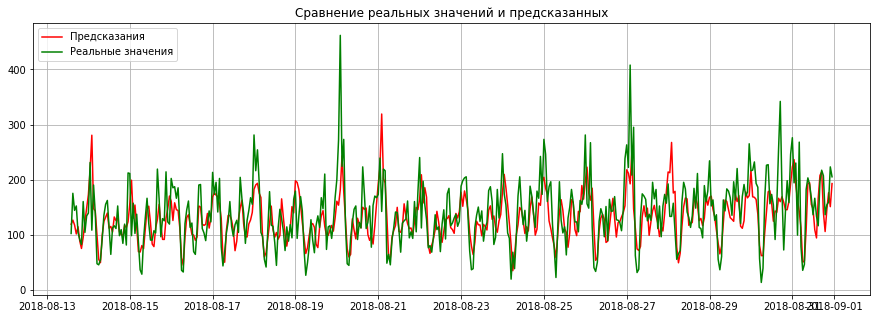

In [28]:
rmse = ml_result(LinearRegression(fit_intercept=True, normalize=False))
results.loc[0, 'rmse_test'] = rmse
results

Проверим модель дерева решений

,model,best_parameters_train,RMSE_train,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-27.020278,45.529337
1,DecisionTreeRegressor,"{'max_depth': 5, 'min_samples_split': 27}",-29.843421,51.117299
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 146}",-25.692406,NaN
3,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-26.304514,NaN
4,LGBMRegressor,{'n_estimators': 41},-25.672197,NaN


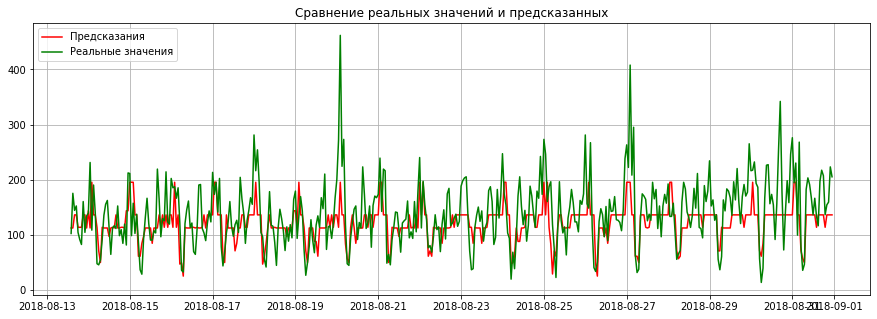

In [29]:
rmse = ml_result(DecisionTreeRegressor(random_state=12345, max_depth=5, min_samples_split=27))
results.loc[1, 'rmse_test'] = rmse
results

Проверим модель случайного дерева

,model,best_parameters_train,RMSE_train,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-27.020278,45.529337
1,DecisionTreeRegressor,"{'max_depth': 5, 'min_samples_split': 27}",-29.843421,51.117299
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 146}",-25.692406,42.533754
3,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-26.304514,NaN
4,LGBMRegressor,{'n_estimators': 41},-25.672197,NaN


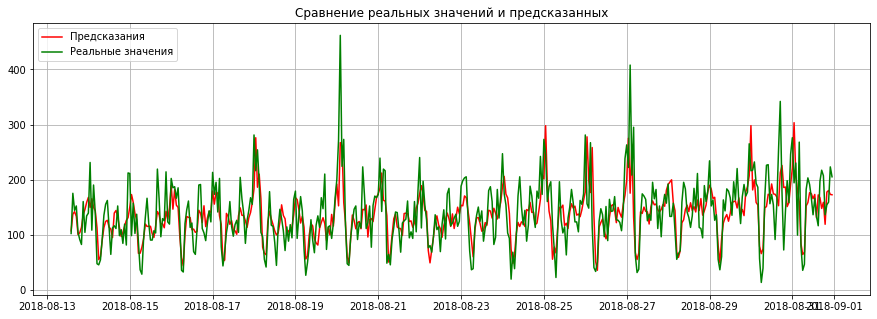

In [30]:
rmse = ml_result(RandomForestRegressor(random_state=12345, max_depth=18, n_estimators=146))
results.loc[2, 'rmse_test'] = rmse
results

Проверим модель CatBoostRegressor

0:	learn: 31.5607624	total: 3.46ms	remaining: 69.1ms
1:	learn: 28.5680900	total: 6.61ms	remaining: 62.8ms
2:	learn: 27.0712094	total: 9.48ms	remaining: 56.9ms
3:	learn: 26.3023613	total: 12.6ms	remaining: 53.3ms
4:	learn: 26.2301891	total: 15.6ms	remaining: 49.8ms
5:	learn: 25.8022023	total: 18.7ms	remaining: 46.7ms
6:	learn: 25.4047020	total: 22ms	remaining: 44.1ms
7:	learn: 25.3206408	total: 25.1ms	remaining: 40.7ms
8:	learn: 25.0467501	total: 27.7ms	remaining: 37ms
9:	learn: 24.8390974	total: 30.4ms	remaining: 33.4ms
10:	learn: 24.5930899	total: 33.5ms	remaining: 30.5ms
11:	learn: 24.5085691	total: 36.4ms	remaining: 27.3ms
12:	learn: 24.2715924	total: 39.4ms	remaining: 24.2ms
13:	learn: 24.0960918	total: 42.6ms	remaining: 21.3ms
14:	learn: 24.0584693	total: 45.6ms	remaining: 18.2ms
15:	learn: 23.9130058	total: 48.2ms	remaining: 15.1ms
16:	learn: 23.8091778	total: 51ms	remaining: 12ms
17:	learn: 23.5838972	total: 54.1ms	remaining: 9.02ms
18:	learn: 23.3689232	total: 56.9ms	remaining:

,model,best_parameters_train,RMSE_train,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-27.020278,45.529337
1,DecisionTreeRegressor,"{'max_depth': 5, 'min_samples_split': 27}",-29.843421,51.117299
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 146}",-25.692406,42.533754
3,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-26.304514,43.885191
4,LGBMRegressor,{'n_estimators': 41},-25.672197,NaN


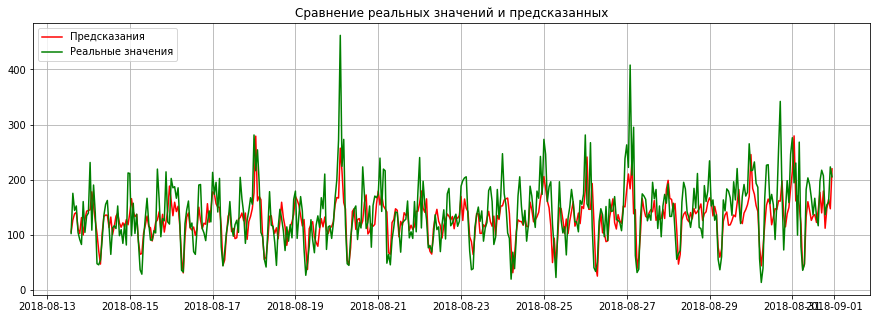

In [31]:
rmse = ml_result(CatBoostRegressor(loss_function="RMSE", learning_rate = 0.5, depth=4, iterations=21))
results.loc[3, 'rmse_test'] = rmse
results

Проверим модель LGBMRegressor

,model,best_parameters_train,RMSE_train,rmse_test
0,LinearRegression,"{'fit_intercept': True, 'normalize': False}",-27.020278,45.529337
1,DecisionTreeRegressor,"{'max_depth': 5, 'min_samples_split': 27}",-29.843421,51.117299
2,RandomForestRegressor,"{'max_depth': 18, 'n_estimators': 146}",-25.692406,42.533754
3,CatBoostRegressor,"{'depth': 4, 'iterations': 21}",-26.304514,43.885191
4,LGBMRegressor,{'n_estimators': 41},-25.672197,42.459375


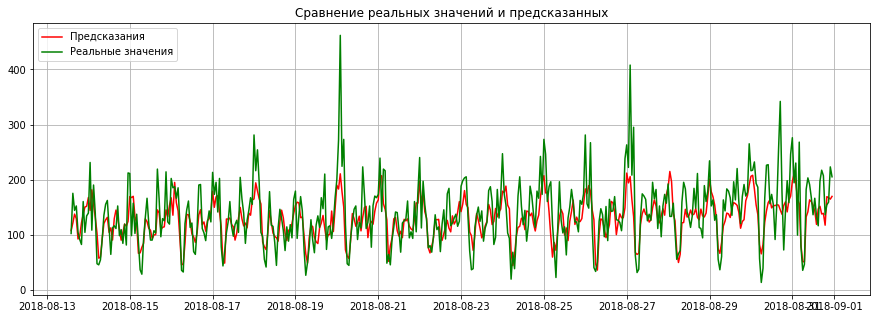

In [32]:
rmse = ml_result(LGBMRegressor(random_state=12345, n_estimators=41))
results.loc[4, 'rmse_test'] = rmse
results

<a id="step_6"></a>
## Общий вывод

Для получения результата в принятии решений в условиях задачи мной выполнено:

Сортировка по индексу, проверка на монотонность, рассемплирование временного ряда по часу, выявлены тренды и сезонность.

Обучил моделями линейного леса, дерева решений, случайного дерева, CatBoostRegressor и LGBMRegressor

Нашел лучшие гиперпараметры данных моделей при обучении на обучающей выборке

Проверили модели с лучшими гиперпараметрами на тестовой выборке

В процессе проверки наших моделей на тестовой выборке все модели, кроме модели дерева решений уложились в значение метрики RMSE не более 48. Наилучшие значения оказались у модели LGBMRegressor. Данную модель можно рекомендовать к исполнению.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48